In [2]:
import copy
import operator
import math
from itertools import product as iter_product
from functools import reduce
from tabulate import tabulate

from PIL import Image
from random import *
import matplotlib.pyplot as plt
import matplotlib.colors as color
%matplotlib inline

def show(*pics):
    p1 = pics[0]
    fig = plt.figure()
    plt.subplots(1,len(pics),figsize=(len(pics)*7,7))
    for i,pic in enumerate(pics):
        plt.subplot(1, len(pics), i+1)
        plt.imshow(pic, interpolation='none')

In [3]:
################################
# Generalized Distributive Law #
################################

# versteckt in der Präsentation

class SemiRing(object):
    "A commutative semiring. Inverse multiplication can be set to None if not \
    available. Then, variable elimination (adding evidence) will be \
    unnormalized."
    def __init__(self, add, zero, mul, invmul, one):
        self.add = add
        self.zero = zero
        self.mul = mul
        self.invmul = invmul
        self.one = one

def unity(ring, domain={}):
    "Create a function that returns the ring's multiplicative \
    identity for any argument"
    def u(**args):
        return ring.one
    u.domain = domain
    return u

def marginalize_out(f, ring, var):
    "Marginalize out the given variable according to the addition \
    operator of the ring and the domain of the variable"
    marginalized_domain = {k:v for k,v in f.domain.items() if k is not var}
    results = {}
    for args in iter_product(*marginalized_domain.values()):
        expanded_args = {k:args[i] for i,k in enumerate(marginalized_domain.keys())}
        total = ring.zero
        for val in f.domain[var]:
            expanded_args[var] = val
            total = ring.add(total, f(**expanded_args))
        results[args] = total
    def marginalized(**args):
        t = tuple(args[var] for var in marginalized_domain.keys())
        return results[t]
    marginalized.domain = marginalized_domain
    return marginalized

def marginalize(f, ring, keep_var):
    "Marginalize out all variables that are not (in) keep_var"
    if not type(keep_var) == list:
        keep_var = [keep_var]
    new_func = f
    for arg in f.domain:
        if not arg in keep_var:
            new_func = marginalize_out(new_func, ring, arg)
    return new_func

def join(f1, f2, ring):
    "The functions are merged using the ring's multiplication operator. \
    The new domain is the union of the original domains."
    joined_domain = f1.domain.copy()
    joined_domain.update(f2.domain.items())
    results = {}
    arg_list_total = list(joined_domain.keys())
    for args in iter_product(*joined_domain.values()):
        expanded_args1 = {k:args[i] for i,k in enumerate(joined_domain) if k in f1.domain}
        expanded_args2 = {k:args[i] for i,k in enumerate(joined_domain) if k in f2.domain}
        results[args] = ring.mul(f1(**expanded_args1), f2(**expanded_args2))
    def joined(**args):
        t = tuple(args[var] for var in joined_domain.keys())
        return results[t]
    joined.domain = joined_domain
    return joined

def eliminate(f, ring, normalize=False, **elim):
    "Fix the given variables to a fixed value. The resuling function \
    can be normalized if an inverse multiplication operator is available."
    if normalize:
        var_only = marginalize(f, ring, list(elim.keys()))
        normalization_constant = var_only(**elim)
    def eliminated(**args):
        args.update(elim)
        result = f(**args)
        if normalize:
            return ring.invmul(result, normalization_constant)
        else:
            return result
    eliminated.domain = {k:f.domain[k] for k in f.domain.keys() if k not in elim}
    return eliminated

def normalize(f, ring, amount=None):
    "If amount is not set, then we normalize by inverse multiplication \
    (according to the ring) by the sum of all function values."
    if amount == None:
        amount = ring.zero
        for args in iter_product(*f.domain.values()):
            expanded_args = {k:args[i] for i,k in enumerate(f.domain.keys())}
            amount = ring.add(amount, f(**expanded_args))
    def normalized(**args):
        return ring.invmul(f(**args), amount)
    normalized.domain = f.domain
    return normalized

In [4]:
##########################################
# Operationen auf diskreten Verteilungen #
##########################################

sum_product = SemiRing(operator.add, 0.0, operator.mul, operator.truediv, 1.0)

def Marginal(P, var):
    return marginalize(P, sum_product, var)

def Joint(P1, P2):
    return join(P1, P2, sum_product)

def Observe(P, **obs):
    return eliminate(P, sum_product, normalize=True, **obs)

def PrintTable(f):
    table = [(", ".join(f.domain), "Value" )]
    for args in iter_product(*[f.domain[x] for x in f.domain.keys()]):
        expanded_args = {k:args[i] for i,k in enumerate(f.domain.keys())}
        table.append((", ".join(map(str, list(args))), str(f(**expanded_args))))
    print(tabulate(table, headers="firstrow"))

In [5]:
##############################
# Beispielverteilungen Alarm #
##############################

def P_Dieb(D):
    p = 0.001
    if D == True:
        return p
    else:
        return 1-p
P_Dieb.domain = {'D':[True, False]}

def P_Sturm(S):
    p = 0.01
    if S == True:
        return p
    else:
        return 1-p
P_Sturm.domain = {'S':[True, False]}

def CP_Radio(R,S):
    p = {} # P(R|S)
    p[(True, True)] = 0.9
    p[(False, True)] = 0.1
    p[(True, False)] = 0.02
    p[(False, False)] = 1.0 - 0.02
    return p[(R,S)]
CP_Radio.domain = {'R':[True, False], 'S':[True, False]}

def CP_Alarm(A,D,S):
    p = {} # P(A|D,S)
    p[(True, True, True)] = 0.95
    p[(False, True, True)] = 0.05
    p[(True, True, False)] = 0.9
    p[(False, True, False)] = 0.1
    p[(True, False, True)] = 0.5
    p[(False, False, True)] = 0.5
    p[(True, False, False)] = 0.01
    p[(False, False, False)] = 1-0.01
    return p[(A,D,S)]
CP_Alarm.domain = {'A':[True, False], 'D':[True, False], 'S':[True, False]}

def CP_Wachdienst(W,A):
    p = {} # P(W|A)
    p[(True, True)] = 0.9
    p[(False, True)] = 0.1
    p[(True, False)] = 0.1
    p[(False, False)] = 0.9
    return p[(W,A)]
CP_Wachdienst.domain = {'W':[True, False], 'A':[True, False]}

Zur Erinnerung: Die Funktionen sind
- `P_Dieb(D)`: $P(D) = \psi_D(x_D)$
- `P_Sturm(S)`: $P(S) = \psi_S(x_S)$
- `CP_Radio(R,S)`: $P(R\,|\,S) = \psi_{RS}(\mathbf x_{RS})$
- `CP_Alarm(A,D,S)`: $P(A\,|\,D,S) = \psi_{ADS}(\mathbf x_{ADS})$
- `CP_Wachdienst(W,A)`: $P(W\,|\,A) = \psi_{WA}(\mathbf x_{WA})$

In [27]:
P_RS = Joint(P_Sturm, CP_Radio)
PrintTable(P_RS)

P_R = Marginal(P_RS, "R")
PrintTable(P_R)

S, R            Value
------------  -------
True, True     0.009
True, False    0.001
False, True    0.0198
False, False   0.9702
R        Value
-----  -------
True    0.0288
False   0.9712


## Faktorgraph

In [31]:
class Node(object):
    def __init__(self, name, func):
        self.name = name
        self.func = func # for variable nodes, func is the multiplicative unity
        self.neighbours = []
        self.received_messages = {} # maps neighbour-names to messages

class VariableNode(Node):
    pass

class FactorNode(Node):
    pass

def create_factor(name, func):
    return FactorNode(name, func)

def create_variable(name, domain):
    func = unity(sum_product, {name:domain})
    return VariableNode(name, func)

In [32]:
X_D = create_variable("D", [True, False])
X_S = create_variable("S", [True, False])
X_A = create_variable("A", [True, False])
X_R = create_variable("R", [True, False])
X_W = create_variable("W", [True, False])

psi_D = create_factor("psi_D", P_Dieb)
psi_S = create_factor("psi_S", P_Sturm)
psi_RS = create_factor("psi_RS", CP_Radio)
psi_ADS = create_factor("psi_ADS", CP_Alarm)
psi_WA = create_factor("psi_WA", CP_Wachdienst)

psi_D.neighbours = [X_D]
psi_S.neighbours = [X_S]
psi_RS.neighbours = [X_R, X_S]
psi_ADS.neighbours = [X_A, X_D, X_S]
psi_WA.neighbours = [X_W, X_A]

## Belief Propagation
\begin{align*}
    m_{i\to j}(x_i) &= \prod_{k \in N(i)\setminus j}m_{k \to i}(x_i)\\
    m_{j\to i}(x_i) &= \sum_{\substack{\mathbf x_j\in \mathcal X_j\\x_{j_i} =
        x_i}} \Big[\psi_j(\mathbf x_j) \prod_{h\in j \setminus i} m_{h\to
      j}(x_{j_h})\Big]
  \end{align*}

In [33]:
def Message(source, target):
    f = source.func # Identität '1' wenn source ein Variablenknoten
    for neighbour, m in source.received_messages.items():
        if neighbour == target.name:
            continue
        f = Joint(f, m)
    if type(source) == FactorNode:
        f = Marginal(f, target.name)
    return f

def SendMessage(source, target):
    m = Message(source, target)
    target.received_messages[source.name] = m

In [34]:
m = Message(psi_S, X_S)
PrintTable(m)

S        Value
-----  -------
True      0.01
False     0.99


In [35]:
m2 = Message(X_R, psi_RS)
PrintTable(m2)

R        Value
-----  -------
True         1
False        1


In [36]:
# Nachrichten vorwärts
SendMessage(X_R, psi_RS)
SendMessage(psi_RS, X_S)
SendMessage(psi_S, X_S)
SendMessage(X_S, psi_ADS)
SendMessage(psi_D, X_D)
SendMessage(X_D, psi_ADS)
SendMessage(X_W, psi_WA)
SendMessage(psi_WA, X_A)
SendMessage(X_A, psi_ADS)

## Und zurück
SendMessage(psi_ADS, X_D)
SendMessage(psi_ADS, X_A)
SendMessage(X_A, psi_WA)
SendMessage(psi_WA, X_W)
SendMessage(psi_ADS, X_S)
SendMessage(X_S, psi_RS)
SendMessage(psi_RS, X_R)

### Wie wahrscheinlich ruft der Wachdienst an?

In [39]:
# Lokal anhand der Nachrichten berechnen
def LocalMarginal(node):
    f = node.func
    for m in node.received_messages.values():
        f = Joint(f,m)
    return f

P_W2 = LocalMarginal(X_W)
print(P_W2(W=True))

0.11262848


In [38]:
# Über die große Verbundverteilung (Tabelle) berechnen
P_DSRAW = reduce(Joint, [P_Dieb, P_Sturm, CP_Radio, CP_Alarm, CP_Wachdienst])
P_W = Marginal(P_DSRAW, 'W')
print(P_W(W=True))

0.11262848


## Maximum A Posteriori

In [41]:
max_product = SemiRing(max, float("-inf"), operator.mul, operator.truediv, 1.0)

def MaxMarginal(P,var):
    return marginalize(P, max_product, var)

def MaxJoint(P1, P2):
    return join(P1, P2, max_product)

def MaxMessage(source, target):
    f = source.func # Identität '1' wenn source ein Variablenknoten
    for neighbour, m in source.received_messages.items():
        if neighbour == target.name:
            continue
        f = MaxJoint(f, m)
    if type(source) == FactorNode:
        f = MaxMarginal(f, target.name)
    return f

def SendMaxMessage(source, target):
    m = MaxMessage(source, target)
    target.received_messages[source.name] = m
    
def LocalMaxMarginal(node):
    f = node.func
    for m in node.received_messages.values():
        f = MaxJoint(f,m)
    return f

def argmax(f):
    "Find the argmax by brute force"
    ma = None
    mav = float('-inf')
    for args in iter_product(*f.domain.values()):
        expanded_args = {k:args[i] for i,k in enumerate(f.domain.keys())}
        v = f(**expanded_args)
        if v > mav:
            ma, mav = args, v
    return ma[0]

In [42]:
def P_DiebBeobachtet(D):
    if D == True:
        return 1
    else:
        return 0
P_DiebBeobachtet.domain = {'D':[True, False]}

In [43]:
X_D = create_variable("D", [True, False])
X_S = create_variable("S", [True, False])
X_A = create_variable("A", [True, False])
X_R = create_variable("R", [True, False])
X_W = create_variable("W", [True, False])

psi_D = create_factor("psi_D", P_DiebBeobachtet)
psi_S = create_factor("psi_S", P_Sturm)
psi_RS = create_factor("psi_RS", CP_Radio)
psi_ADS = create_factor("psi_ADS", CP_Alarm)
psi_WA = create_factor("psi_WA", CP_Wachdienst)

psi_D.neighbours = [X_D]
psi_S.neighbours = [X_S]
psi_RS.neighbours = [X_R, X_S]
psi_ADS.neighbours = [X_A, X_D, X_S]
psi_WA.neighbours = [X_W, X_A]

SendMaxMessage(X_R, psi_RS)
SendMaxMessage(psi_RS, X_S)
SendMaxMessage(psi_S, X_S)
SendMaxMessage(X_S, psi_ADS)
SendMaxMessage(psi_D, X_D)
SendMaxMessage(X_D, psi_ADS)
SendMaxMessage(X_W, psi_WA)
SendMaxMessage(psi_WA, X_A)
SendMaxMessage(X_A, psi_ADS)
SendMaxMessage(psi_ADS, X_D)
SendMaxMessage(psi_ADS, X_A)
SendMaxMessage(X_A, psi_WA)
SendMaxMessage(psi_WA, X_W)
SendMaxMessage(psi_ADS, X_S)
SendMaxMessage(X_S, psi_RS)
SendMaxMessage(psi_RS, X_R)

In [17]:
X_D_max = argmax(LocalMaxMarginal(X_D))
print("Diebstahl: " + str(X_D_max))

X_S_max = argmax(LocalMaxMarginal(X_S))
print("Sturm: " + str(X_S_max))

X_A_max = argmax(LocalMaxMarginal(X_A))
print("Alarm: " + str(X_A_max))

X_W_max = argmax(LocalMaxMarginal(X_W))
print("Wachdienst: " + str(X_W_max))

X_R_max = argmax(LocalMaxMarginal(X_R))
print("Radio: " + str(X_R_max))

Diebstahl: True
Sturm: False
Alarm: True
Wachdienst: True
Radio: False


## Bayes'sche Bildrestauration

In [44]:
max_sum = SemiRing(max, float("-inf"), operator.add, operator.sub, 1.0)

def MaxSumMarginal(P,var):
    return marginalize(P, max_sum, var)

def MaxSumJoint(P1, P2):
    return join(P1, P2, max_sum)

def MaxSumMessage(source, target):
    f = source.func # Identität '1' wenn source ein Variablenknoten
    for neighbour, m in source.received_messages.items():
        if neighbour == target.name:
            continue
        f = MaxSumJoint(f, m)
    if type(source) == FactorNode:
        f = MaxSumMarginal(f, target.name)
    return f

def SendMaxSumMessage(source, target):
    m = MaxSumMessage(source, target)
    target.received_messages[source.name] = m
    
def LocalMaxSumMarginal(node):
    f = node.func
    for m in node.received_messages.values():
        f = MaxSumJoint(f,m)
    return f

## Rauschen einfügen

<Figure size 432x288 with 0 Axes>

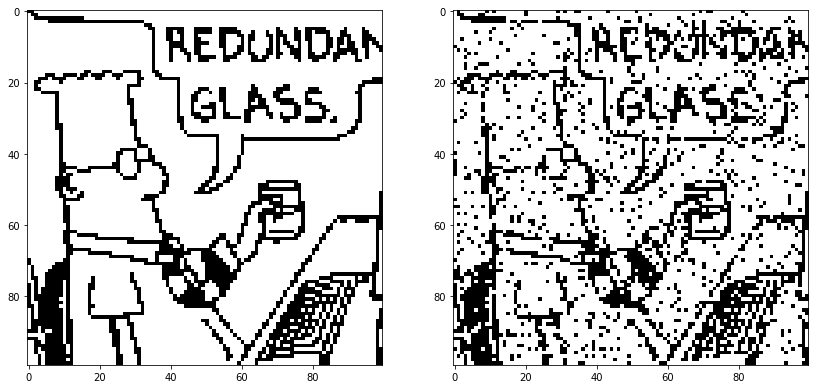

In [45]:
o = Image.open('dilbert/orig.png')
(width,height) = o.size

b = o.copy()
p = 0.1

data = b.getdata()
for x,y in iter_product(range(width), range(height)):
    if random() > 1-p:
        if data.getpixel((x,y)) == 0:
            data.putpixel((x,y),255)
        else:
            data.putpixel((x,y),0)
show(o,b)

## MRF aufstellen

In [46]:
# Liste mit Nachbarschafts-Tupeln
neighbours = []
for x in range(width):
    for y in range(height):
        if x+1 < width:
            neighbours.append(((x,y),(x+1,y)))
        if y+1 < height:
            neighbours.append(((x,y),(x,y+1)))

In [48]:
def createVariable(x,y):
    name = str(x) + "," + str(y)
    return create_variable(name, [0,255])

def createLocalFactor(x,y,var):
    orig_value = data.getpixel((x,y))
    def localEnergy(**arg):
        if arg[var.name] == orig_value:
            return math.log(1-p)
        else:
            return math.log(p)
    localEnergy.domain = {var.name:[0,255]}
    lf = create_factor("local_" + var.name, localEnergy)
    lf.neighbours = [var]
    var.neighbours.append(lf)
    return lf

alpha = 0.85

def createNeighbourFactor(var1, var2):
    def neighbourEnergy(**args):
        if args[var1.name] == args[var2.name]:
            return 0
        else:
            return -alpha
    neighbourEnergy.domain = var1.func.domain.copy()
    neighbourEnergy.domain.update(var2.func.domain)
    nf = create_factor(var1.name + ":" + var2.name, neighbourEnergy)
    nf.neighbours = [var1,var2]
    var1.neighbours.append(nf)
    var2.neighbours.append(nf)
    return nf

variables = {} # Mapping vom Name auf die Variable
local_factors = []
neighbour_factors = []

for x in range(width):
    for y in range(height):
        var = createVariable(x,y)
        variables[var.name] = var
        local_factors.append(createLocalFactor(x,y,var))
        
for (x1,y1),(x2,y2) in neighbours:
    var1 = variables[str(x1) + "," + str(y1)]
    var2 = variables[str(x2) + "," + str(y2)]
    neighbour_factors.append(createNeighbourFactor(var1, var2))

## Inferenz

In [49]:
# Die lokalen Faktoren senden nur einmal
for lf in local_factors:
    for n in lf.neighbours:
            SendMaxSumMessage(lf, n)

# Die binären Knoten (Variablen, Faktoren) senden zufällig
nodes = list(variables.values()) + neighbour_factors
for i in range(5):
    shuffle(nodes)
    for node in nodes:
        for neighbour in node.neighbours:
            SendMaxSumMessage(node, neighbour)

<Figure size 432x288 with 0 Axes>

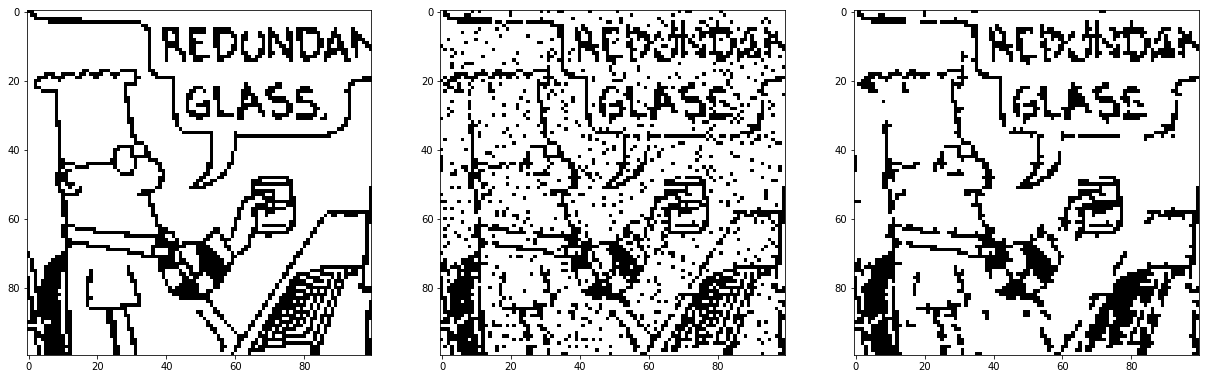

In [50]:
r = Image.new("1", b.size)
r_data = r.getdata()
for x,y in iter_product(range(width), range(height)):
    var = variables[str(x) + "," + str(y)]
    value = argmax(LocalMaxSumMarginal(var))
    r_data.putpixel((x,y), value)
show(o,b,r)

# Stereo Matching

<Figure size 432x288 with 0 Axes>

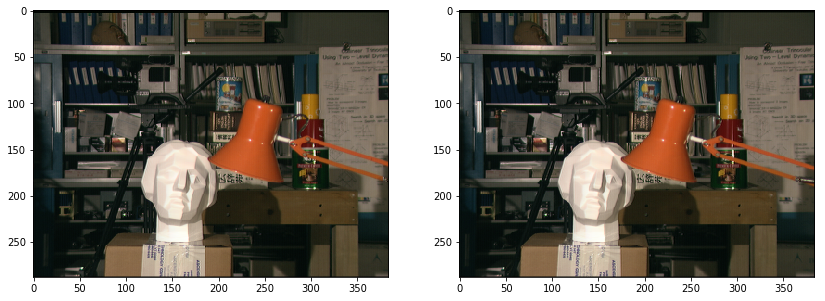

In [51]:
# Resize images to width=100
left = Image.open('tsukuba/left.png')
right = Image.open('tsukuba/right.png')
stereo_width, stereo_height = left.size
show(left, right)

### Den Graph erzeugen

In [25]:
stereo_neighbours = []
for x in range(stereo_width):
    for y in range(stereo_height):
        if x+1 < stereo_width:
            stereo_neighbours.append(((x,y),(x+1,y)))
        if y+1 < stereo_height:
            stereo_neighbours.append(((x,y),(x,y+1)))

In [26]:
max_diff = 10

def createPixel(x,y):
    name = str(x) + "," + str(y)
    return create_variable(name, range(max_diff))

def color_difference(p1, p2):
    return abs(p1[0]-p2[0])+ abs(p1[1]-p2[1]) + abs(p1[2]-p2[2])
    
left_data = left.getdata()
right_data = right.getdata()
    
def createColorDifferenceFactor(x,y,var):
    diff = max_diff*[None]
    for i in range(max_diff):
        xpos = x+i
        if xpos >= stereo_width:
            diff[i] = float('-inf')
        else:
            diff[i] = -color_difference(left_data.getpixel((x,y)), right_data.getpixel((xpos,y)))
    def localEnergy(**arg):
        return diff[arg[var.name]]
    localEnergy.domain = {var.name:range(max_diff)}
    f = create_factor("colordiff_" + var.name, localEnergy)
    f.neighbours = [var]
    var.neighbours.append(f)
    return f

stereo_alpha = 5
    
def createNeighbourDifferenceFactor(var1, var2):
    def neighbourEnergy(**args):
        return -abs(args[var1.name] - args[var2.name]) * stereo_alpha
    neighbourEnergy.domain = var1.func.domain.copy()
    neighbourEnergy.domain.update(var2.func.domain)
    f = create_factor(var1.name + ":" + var2.name, neighbourEnergy)
    f.neighbours = [var1,var2]
    var1.neighbours.append(f)
    var2.neighbours.append(var2)
    return f

stereo_variables = {}
stereo_local_factors = []
stereo_neighbour_factors = []   

for x in range(stereo_width):
    for y in range(stereo_height):
        var = createPixel(x,y)
        stereo_variables[var.name] = var
        stereo_local_factors.append(createColorDifferenceFactor(x,y,var))
        
for (x1,y1),(x2,y2) in stereo_neighbours:
    var1 = stereo_variables[str(x1) + "," + str(y1)]
    var2 = stereo_variables[str(x2) + "," + str(y2)]
    stereo_neighbour_factors.append(createNeighbourDifferenceFactor(var1, var2))

### Inferenz

In [27]:
## Achtung! Die Inferenz dauert lange. Daher auskommentiert.

## Die lokalen Faktoren senden nur einmal
#for lf in stereo_local_factors:
#    for n in lf.neighbours:
#            SendMaxSumMessage(lf, n)
#
## Die binären Knoten (Variablen, Faktoren) senden zufällig
#nodes = list(stereo_variables.values()) + stereo_neighbour_factors
#for i in range(10):
#    shuffle(nodes)
#    for node in nodes:
#        for neighbour in node.neighbours:
#            SendMaxSumMessage(node, neighbour)

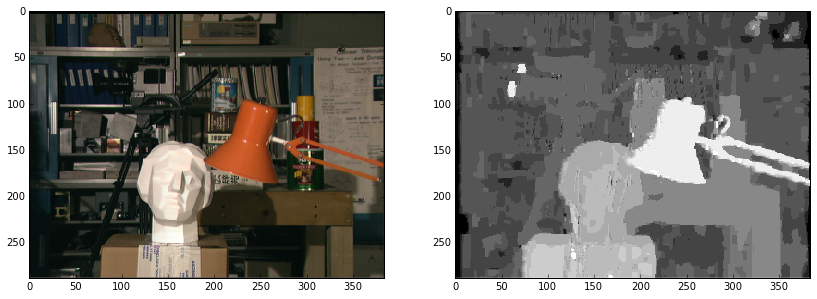

In [28]:
## Save the depth-map
#depth = Image.new("RGB", left.size)
#depth_data = depth.getdata()
#for x,y in iter_product(range(stereo_width), range(stereo_height)):
#    var = stereo_variables[str(x) + "," + str(y)]
#    value = int(argmax(LocalMaxSumMarginal(var)) / float(max_diff-1) * 255)
#    depth_data.putpixel((x,y), tuple([value,value,value]))
#depth.save("depth.bmp")

## Load the saved depth-map
depth = Image.open("depth.bmp")  
show(left, depth)